# Mask Detection

## Loading the required libraries and packages

In [1]:
import os
import random
import shutil
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
from os import getcwd

## Checking all the data that is available

In [8]:
print(len(os.listdir(f"{getcwd()}/data/with_mask/")))
print(len(os.listdir(f"{getcwd()}/data/without_mask/")))

3725
3828


## Creating specific directories for training and testing data

In [22]:

os.mkdir(f"{getcwd()}/tmp")
os.mkdir(f"{getcwd()}/tmp/training/")
os.mkdir(f"{getcwd()}/tmp/testing/")
os.mkdir(f"{getcwd()}/tmp/training/with_mask/")
os.mkdir(f"{getcwd()}/tmp/training/without_mask/")
os.mkdir(f"{getcwd()}/tmp/testing/with_mask/")
os.mkdir(f"{getcwd()}/tmp/testing/without_mask/")


## Splitting data separately for training and testing

In [23]:
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    files = os.listdir(SOURCE)
    files = random.sample(files,len(files))
    k = 0
    for file in files:
        k=k+1
        source = os.path.join(SOURCE,file)
        dest_tr = os.path.join(TRAINING,file)
        dest_tt = os.path.join(TESTING,file)
        if os.path.getsize(source)!=0:
            if (k<=SPLIT_SIZE*(len(files))):
                copyfile(source,dest_tr)
            else:
                copyfile(source,dest_tt)


withmask_SOURCE_DIR = f"{getcwd()}/data/with_mask/"
TRAINING_withmask_DIR = f"{getcwd()}/tmp/training/with_mask/"
TESTING_withmask_DIR = f"{getcwd()}/tmp/testing/with_mask/"
withoutmask_DIR = f"{getcwd()}/data/without_mask/"
TRAINING_withoutmask_DIR = f"{getcwd()}/tmp/training/without_mask/"
TESTING_withoutmask_DIR = f"{getcwd()}/tmp/testing/without_mask/"

split_size = .9
split_data(withmask_SOURCE_DIR, TRAINING_withmask_DIR, TESTING_withmask_DIR, split_size)
split_data(withoutmask_DIR, TRAINING_withoutmask_DIR, TESTING_withoutmask_DIR, split_size)

## Checking all the training and testing data available

In [24]:
print(len(os.listdir(f"{getcwd()}/tmp/training/with_mask/")))
print(len(os.listdir(f"{getcwd()}/tmp/training/without_mask/")))
print(len(os.listdir(f"{getcwd()}/tmp/testing/with_mask/")))
print(len(os.listdir(f"{getcwd()}/tmp/testing/without_mask/")))


3352
3445
373
383


## Creating the model

In [25]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), 
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(), 
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'), 
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('cats') and 1 for the other ('dogs')
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=RMSprop(lr=0.001), loss='binary_crossentropy', metrics=['acc'])

## Loading and preparing data in appropriate format for training

In [41]:
TRAINING_DIR = f"{getcwd()}/tmp/training/"
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=34,
                                                    class_mode='binary',
                                                    target_size=(150, 150))

VALIDATION_DIR = f"{getcwd()}/tmp/testing/"
validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                    batch_size=34,
                                                    class_mode='binary',
                                                    target_size=(150, 150))




Found 6797 images belonging to 2 classes.
Found 756 images belonging to 2 classes.


## Training the model

In [52]:
history = model.fit(train_generator,
                              epochs=3,
                              verbose=1,
                              validation_data=validation_generator)


Epoch 1/3
200/200 [==============================] - 265s 1s/step - loss: 0.2167 - acc: 0.9195 - val_loss: 0.2126 - val_acc: 0.9193
Epoch 2/3
200/200 [==============================] - 307s 2s/step - loss: 0.2126 - acc: 0.9228 - val_loss: 0.3040 - val_acc: 0.9153
Epoch 3/3
200/200 [==============================] - 340s 2s/step - loss: 0.1894 - acc: 0.9303 - val_loss: 0.1487 - val_acc: 0.9537


## Plotting loss and accuracy

Text(0.5, 1.0, 'Training and validation loss')

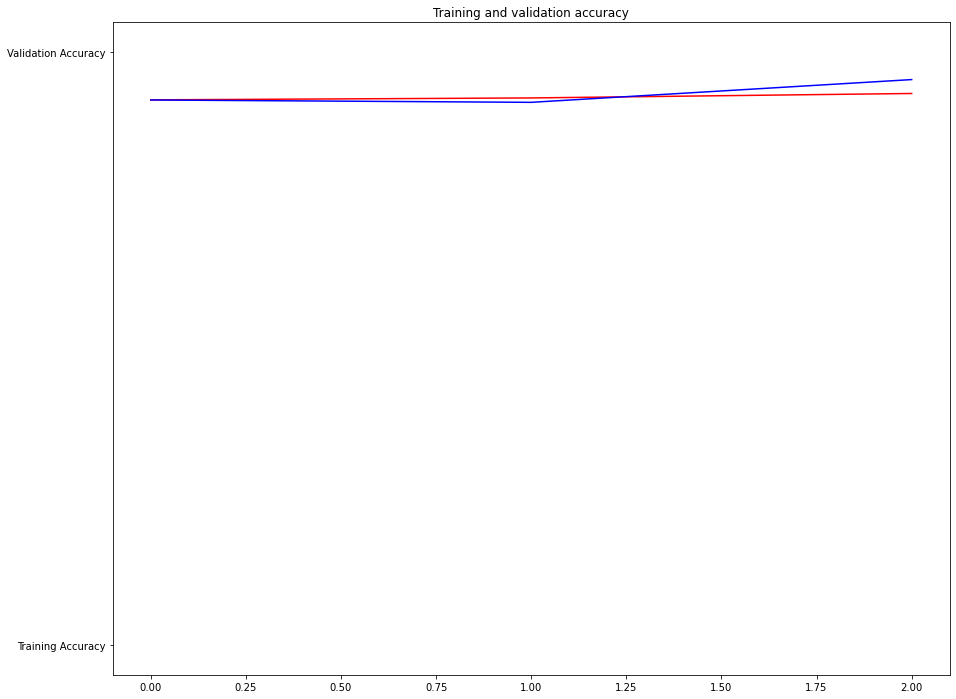

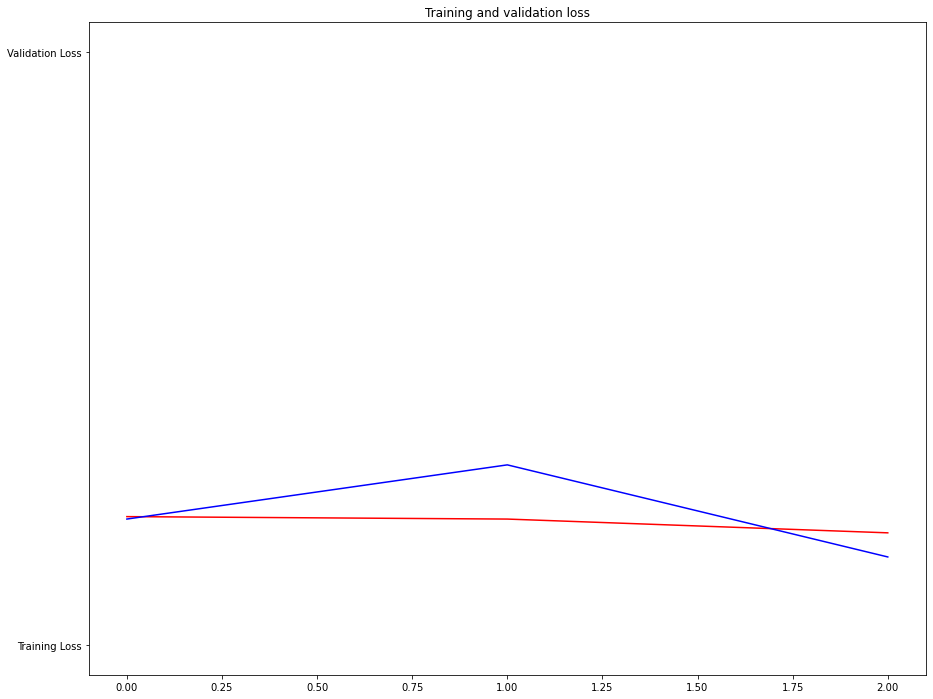

In [53]:
# PLOT LOSS AND ACCURACY
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = [15,12]
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")


plt.title('Training and validation loss')

# Desired output. Charts with training and validation metrics. No crash :)

Person in the image is not wearing mask


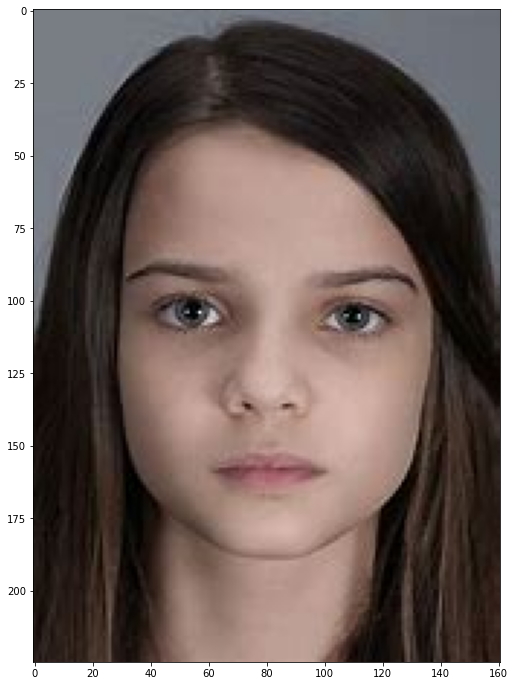

In [76]:
def predict(path):
    import numpy as np
    from tensorflow.keras.preprocessing.image import img_to_array, load_img
    img = load_img(path, target_size=(150, 150))  # this is a PIL image
    x = img_to_array(img)  # Numpy array with shape (150, 150, 3)
    x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)
    x /= 255
    return model.predict(x)
pred = predict('lady2.jfif')
if (pred<=0.5):
    print("Person in the image is wearing mask")
else:
    print("Person in the image is not wearing mask")
image = cv.imread('lady2.jfif',cv.IMREAD_COLOR)
image = cv.cvtColor(image,cv.COLOR_BGR2RGB)
from pylab import rcParams
rcParams['figure.figsize'] = [15,12]
plt.imshow(image,cmap='gray')


Person in the image is wearing mask


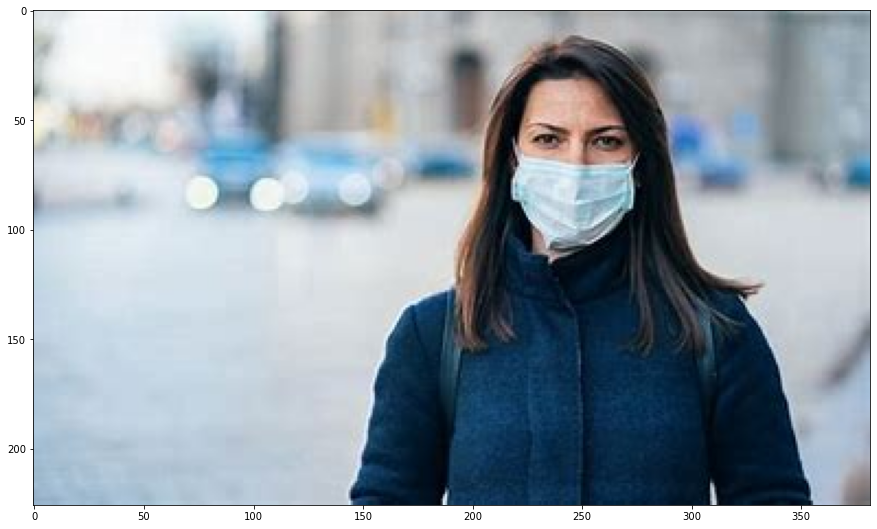

In [77]:
pred = predict('lady.jfif')
if (pred<=0.5):
    print("Person in the image is wearing mask")
else:
    print("Person in the image is not wearing mask")
image = cv.imread('lady.jfif',cv.IMREAD_COLOR)
image = cv.cvtColor(image,cv.COLOR_BGR2RGB)
from pylab import rcParams
rcParams['figure.figsize'] = [15,12]
plt.imshow(image,cmap='gray')
